In [1]:
# importとconstの設定
import numpy as np
import numpy.linalg as LA
from scipy.integrate import odeint #odeint
import matplotlib.pyplot as plt #to draw graphs

# const
ele_size = 1/2*0.02*0.02
poi = 0.2
e = 100
th = 0.98
row = 2400
nmode = 10
delta_t = 0.000004
total_time = 0.01
total_step = int(total_time/delta_t)
hc = 0.02 #減衰定数
load = 100 #外力最大値
load_time = 0.0001
load_step = int(load_time/delta_t)
load_diff = load/load_step

In [2]:
# ファイル読み込み:nodeとeleの設定
node_path = "./one_hole_1_1.1.node"
ele_path = "./one_hole_1_1.1.ele"
# node_path = "~/src/github.com/shirafuji/graduation_thesis/vibration_simulation/one_hole_1_1.1.node"
# ele_path = '~/src/github.com/shirafuji/graduation_thesis/vibration_simulation/one_hole_1_1.1.ele'
with open(node_path) as f_node:
    s_line = f_node.readline()
    number_list = s_line.split()
    nnode_str = number_list[0]
    nnode = int(nnode_str)
    position = np.zeros((nnode, 2), dtype=np.int64)
    for i in range(nnode):
        s_line = f_node.readline()
        number_list = s_line.split()
        x_str = number_list[1]
        y_str = number_list[2]
        x = int(x_str)
        y = int(y_str)
        position[i][0] = x
        position[i][1] = y
with open(ele_path) as f_ele:
    s_line = f_ele.readline()
    number_list = s_line.split()
    nele_str = number_list[0]
    nele = int(nele_str)
    eles = np.zeros((nele, 3), dtype=np.int64)
    for h in range(nele):
        s_line = f_ele.readline()
        number_list = s_line.split()
        i_str = number_list[1]
        j_str = number_list[2]
        k_str = number_list[3]
        i = int(i_str)
        j = int(j_str)
        k = k_str
        eles[h][0] = i
        eles[h][1] = j
        eles[h][2] = k

In [3]:
# 全体剛性行列と全体質量行列・全体集中質量行列の宣言
kt = np.zeros((2*nnode, 2*nnode))
mt = np.zeros((2*nnode, 2*nnode))
imt = np.zeros((2*nnode, 2*nnode))

In [4]:
# 剛性行列と質量行列計算の定義
def calc_ke(ele, position, kt):
    i = ele[0]
    j = ele[1]
    k = ele[2]
    xi = position[i-1][0]
    yi = position[i-1][1]
    xj = position[j-1][0]
    yj = position[j-1][1]
    xk = position[k-1][0]
    yk = position[k-1][1]
    # ひずみ-変位関係
    b = np.zeros((3, 6))
    b[0][0] = yj-yk
    b[0][2] = yk-yi
    b[0][4] = yi-yj
    b[1][1] = xk-xj
    b[1][3] = xi-xk
    b[1][5] = xj-xi
    b[2][0] = xk-xj
    b[2][1] = yj-yk
    b[2][2] = xi-xk
    b[2][3] = yk-yi
    b[2][4] = xj-xi
    b[2][5] = yi-yj
    # 応力-ひずみ関係
    d = np.zeros((3, 3))
    d[0][0] = 1
    d[0][1] = poi
    d[1][0] = poi
    d[1][1] = 1
    d[2][2] = (1-poi)/2
    d = d*e/(1+poi)/(1-poi)
    ke = th*ele_size*np.dot(np.dot(b.T, d), b)
    # 全体剛性行列への組み込み
    kt[2*i-1-1][2*i-1-1] += ke[1-1][1-1]
    kt[2*i-1-1][2*i-1] += ke[1-1][2-1]
    kt[2*i-1][2*i-1-1] += ke[2-1][1-1]
    kt[2*i-1][2*i-1] += ke[2-1][2-1]
    kt[2*i-1-1][2*j-1-1] += ke[1-1][3-1]
    kt[2*i-1-1][2*j-1] += ke[1-1][4-1]
    kt[2*i-1][2*j-1-1] += ke[2-1][3-1]
    kt[2*i-1][2*j-1] += ke[2-1][4-1]
    kt[2*i-1-1][2*k-1-1] += ke[1-1][5-1]
    kt[2*i-1-1][2*k-1] += ke[1-1][6-1]
    kt[2*i-1][2*k-1-1] += ke[2-1][5-1]
    kt[2*i-1][2*k-1] += ke[2-1][6-1]

    kt[2*j-1-1][2*i-1-1] += ke[3-1][1-1]
    kt[2*j-1-1][2*i-1] += ke[3-1][2-1]
    kt[2*j-1][2*i-1-1] += ke[4-1][1-1]
    kt[2*j-1][2*i-1] += ke[4-1][2-1]
    kt[2*j-1-1][2*j-1-1] += ke[3-1][3-1]
    kt[2*j-1-1][2*j-1] += ke[3-1][4-1]
    kt[2*j-1][2*j-1-1] += ke[4-1][3-1]
    kt[2*j-1][2*j-1] += ke[4-1][4-1]
    kt[2*j-1-1][2*k-1-1] += ke[3-1][5-1]
    kt[2*j-1-1][2*k-1] += ke[3-1][6-1]
    kt[2*j-1][2*k-1-1] += ke[4-1][5-1]
    kt[2*j-1][2*k-1] += ke[4-1][6-1]

    kt[2*k-1-1][2*i-1-1] += ke[5-1][1-1]
    kt[2*k-1-1][2*i-1] += ke[5-1][2-1]
    kt[2*k-1][2*i-1-1] += ke[6-1][1-1]
    kt[2*k-1][2*i-1] += ke[6-1][2-1]
    kt[2*k-1-1][2*j-1-1] += ke[5-1][3-1]
    kt[2*k-1-1][2*j-1] += ke[5-1][4-1]
    kt[2*k-1][2*j-1-1] += ke[6-1][3-1]
    kt[2*k-1][2*j-1] += ke[6-1][4-1]
    kt[2*k-1-1][2*k-1-1] += ke[5-1][5-1]
    kt[2*k-1-1][2*k-1] += ke[5-1][6-1]
    kt[2*k-1][2*k-1-1] += ke[6-1][5-1]
    kt[2*k-1][2*k-1] += ke[6-1][6-1]

    return kt

def calc_me(ele, mt):
    i = ele[0]
    j = ele[1]
    k = ele[2]
    me = np.zeros((6, 6))
    me[0][0] = 1/6
    me[0][2] = 1/12
    me[0][4] = 1/12
    me[1][1] = 1/6
    me[1][3] = 1/12
    me[1][5] = 1/12
    me[2][0] = 1/12
    me[2][2] = 1/6
    me[2][4] = 1/12
    me[3][1] = 1/12
    me[3][3] = 1/6
    me[3][5] = 1/12
    me[4][0] = 1/12
    me[4][2] = 1/12
    me[4][4] = 1/6
    me[5][1] = 1/12
    me[5][3] = 1/12
    me[5][5] = 1/6
    me = ele_size*th*row*me
    # 全体質量行列への組み込み
    mt[2*i-1-1][2*i-1-1] += me[1-1][1-1]
    mt[2*i-1-1][2*i-1] += me[1-1][2-1]
    mt[2*i-1][2*i-1-1] += me[2-1][1-1]
    mt[2*i-1][2*i-1] += me[2-1][2-1]
    mt[2*i-1-1][2*j-1-1] += me[1-1][3-1]
    mt[2*i-1-1][2*j-1] += me[1-1][4-1]
    mt[2*i-1][2*j-1-1] += me[2-1][3-1]
    mt[2*i-1][2*j-1] += me[2-1][4-1]
    mt[2*i-1-1][2*k-1-1] += me[1-1][5-1]
    mt[2*i-1-1][2*k-1] += me[1-1][6-1]
    mt[2*i-1][2*k-1-1] += me[2-1][5-1]
    mt[2*i-1][2*k-1] += me[2-1][6-1]

    mt[2*j-1-1][2*i-1-1] += me[3-1][1-1]
    mt[2*j-1-1][2*i-1] += me[3-1][2-1]
    mt[2*j-1][2*i-1-1] += me[4-1][1-1]
    mt[2*j-1][2*i-1] += me[4-1][2-1]
    mt[2*j-1-1][2*j-1-1] += me[3-1][3-1]
    mt[2*j-1-1][2*j-1] += me[3-1][4-1]
    mt[2*j-1][2*j-1-1] += me[4-1][3-1]
    mt[2*j-1][2*j-1] += me[4-1][4-1]
    mt[2*j-1-1][2*k-1-1] += me[3-1][5-1]
    mt[2*j-1-1][2*k-1] += me[3-1][6-1]
    mt[2*j-1][2*k-1-1] += me[4-1][5-1]
    mt[2*j-1][2*k-1] += me[4-1][6-1]

    mt[2*k-1-1][2*i-1-1] += me[5-1][1-1]
    mt[2*k-1-1][2*i-1] += me[5-1][2-1]
    mt[2*k-1][2*i-1-1] += me[6-1][1-1]
    mt[2*k-1][2*i-1] += me[6-1][2-1]
    mt[2*k-1-1][2*j-1-1] += me[5-1][3-1]
    mt[2*k-1-1][2*j-1] += me[5-1][4-1]
    mt[2*k-1][2*j-1-1] += me[6-1][3-1]
    mt[2*k-1][2*j-1] += me[6-1][4-1]
    mt[2*k-1-1][2*k-1-1] += me[5-1][5-1]
    mt[2*k-1-1][2*k-1] += me[5-1][6-1]
    mt[2*k-1][2*k-1-1] += me[6-1][5-1]
    mt[2*k-1][2*k-1] += me[6-1][6-1]

    return mt

def calc_ime(ele, imt):
    i = ele[0]
    j = ele[1]
    k = ele[2]
    ime = np.zeros((6, 6))
    for h in range(6):
        ime[h][h] = 1/3
    ime = ele_size*th*row*ime
    imt[2*i-1-1][2*i-1-1] += ime[1-1][1-1]
    imt[2*i-1][2*i-1] += ime[2-1][2-1]
    imt[2*j-1-1][2*j-1-1] += ime[3-1][3-1]
    imt[2*j-1][2*j-1] += ime[4-1][4-1]
    imt[2*k-1-1][2*k-1-1] += ime[5-1][5-1]
    imt[2*k-1][2*k-1] += ime[6-1][6-1]
    return imt

In [5]:
# 合成行列と質量行列の組み込み繰り返し
for h in range(nele):
    ele = eles[h]
    kt = calc_ke(ele, position, kt)
    mt = calc_me(ele, mt)
    imt = calc_ime(ele, imt)

In [10]:
# 中身確認
print(kt)
print(mt)
print(imt)

[[ 0.02858333  0.01225    -0.02041667 ...  0.          0.
   0.        ]
 [ 0.01225     0.02858333 -0.00408333 ...  0.          0.
   0.        ]
 [-0.02041667 -0.00408333  0.05716667 ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.05716667 -0.00816667
  -0.00816667]
 [ 0.          0.          0.         ... -0.00816667  0.02858333
   0.01225   ]
 [ 0.          0.          0.         ... -0.00816667  0.01225
   0.02858333]]
[[0.0784 0.     0.0392 ... 0.     0.     0.    ]
 [0.     0.0784 0.     ... 0.     0.     0.    ]
 [0.0392 0.     0.2352 ... 0.     0.     0.    ]
 ...
 [0.     0.     0.     ... 0.2352 0.     0.0392]
 [0.     0.     0.     ... 0.     0.0784 0.    ]
 [0.     0.     0.     ... 0.0392 0.     0.0784]]
[[0.1568 0.     0.     ... 0.     0.     0.    ]
 [0.     0.1568 0.     ... 0.     0.     0.    ]
 [0.     0.     0.4704 ... 0.     0.     0.    ]
 ...
 [0.     0.     0.     ... 0.4704 0.     0.    ]
 [0.     0.     0.     ... 0.     

In [8]:
# サブスペース法定義
import time
def subspace(k,m,n,neig):
    start = time.time()
    loop_count = 0
    ramda = np.zeros((neig,1)) #初期固有値
    x = np.random.rand(n,neig) #初期固有ベクトル
    y = np.zeros((n, neig))
    k = np.matrix(k)
    k_inv = np.linalg.inv(k)
    for i in range(1000):
        loop_count+=1
        ramold = ramda.copy()
        y = np.dot(np.dot(k_inv,m),x)
        kg = np.dot(np.dot(y.T, k), y)
        mg = np.dot(np.dot(y.T, m), y)
        mg_inv = np.linalg.inv(mg)
        w,v = LA.eig(np.dot(mg_inv, kg)) #w:固有値,v:固有ベクトル
        for i in range(neig):
            ramda[i][0] = w[i]
        p = v.T
        x = np.dot(y, p)
        for i in range(neig):
            max_val = 0
            for j in range(n):
                x_val = abs(x[j, i])
                if x_val > max_val:
                    max_val = x_val
            for j in range(n):
                x[j, i] = x[j, i]/max_val
        han = (ramda - ramold)/ramda
        max_mod = 0
        for i in range(neig):
            if abs(han[i][0]) > max_mod:
                max_mod = abs(han[i][0])
        if max_mod < 0.001:
            break
    elapsed_time = time.time() - start
    print(elapsed_time)
    return ramda, x, loop_count

In [9]:
# subspace法実行
ramda, x, loop_count = subspace(kt, imt, 2*nnode, nmode)

/opt/anaconda3/envs/graduation_thesis/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part


KeyboardInterrupt: 

In [142]:
print(ramda)
print(x)
print(loop_count)

[[-6.65260015e-11]
 [-3.05709745e-12]
 [ 6.65259889e-11]
 [ 3.05707026e-12]
 [ 5.41770658e-17]
 [ 1.13020585e-17]
 [-1.43320824e-17]
 [-1.31749306e-17]
 [-3.55635353e-19]
 [ 9.27965671e-18]]
[[ 0.28525702-0.94428498j -0.99854958-0.05383984j  0.93822238+0.28235778j
  ...  0.40310522+0.57780967j  0.89312771-0.41258569j
   0.07774146+0.96894012j]
 [-0.28334527+0.95901797j  0.97938413+0.02786224j -0.95739847-0.28877011j
  ... -0.4243984 -0.59941886j -0.90983031+0.41498049j
  -0.082496  -0.9965914j ]
 [ 0.28525702-0.94428498j -0.99854958-0.05383984j  0.93822238+0.28235778j
  ...  0.40310522+0.57780967j  0.89312771-0.41258569j
   0.07774146+0.96894012j]
 ...
 [ 0.02993565+0.54326192j -0.48521599-0.78694095j -0.67816971-0.22365385j
  ... -0.68951694-0.716531j   -0.59824522+0.11407507j
  -0.15274174-0.93971138j]
 [-0.03455058-0.51986735j  0.49656304+0.77793841j  0.65317636+0.21588493j
  ...  0.67374707+0.69736165j  0.57505127-0.1054114j
   0.14945065+0.9108751j ]
 [ 0.03646233+0.53460034j -0.5

In [143]:
# 正のラムダだけ利用する
positive_index = []
for h in range(len(ramda)):
    if ramda[h][0] > 0:
        positive_index.append(h)
positive_nmode = len(positive_index)
positive_ramda = np.zeros((positive_nmode, 1))
positive_x = np.zeros((2*nnode, positive_nmode))
for h in range(positive_nmode):
    index = positive_index[h]
    positive_ramda[h][0] = ramda[index][0]
for h in range(2*nnode):
    for hh in range(positive_nmode):
        index = positive_index[hh]
        positive_x[h, hh] = x[h, hh-index-1]

/opt/anaconda3/envs/graduation_thesis/lib/python3.7/site-packages/ipykernel_launcher.py:15: ComplexWarning: Casting complex values to real discards the imaginary part
  from ipykernel import kernelapp as app


In [146]:
print(positive_ramda)
print(positive_index)
print(positive_x)

[[6.65259889e-11]
 [3.05707026e-12]
 [5.41770658e-17]
 [1.13020585e-17]
 [9.27965671e-18]]
[2, 3, 4, 5, 9]
[[ 0.40310522  0.40310522  0.40310522  0.40310522 -0.04727989]
 [-0.4243984  -0.4243984  -0.4243984  -0.4243984   0.0437613 ]
 [ 0.40310522  0.40310522  0.40310522  0.40310522 -0.04727989]
 ...
 [-0.68951694 -0.68951694 -0.68951694 -0.68951694 -0.10261195]
 [ 0.67374707  0.67374707  0.67374707  0.67374707  0.1021428 ]
 [-0.69504024 -0.69504024 -0.69504024 -0.69504024 -0.10566139]]


In [100]:
# 外力生成(線形の増減)(左辺中心4点に荷重がかかるとする)
ft = np.zeros((total_step, 2*nnode, 1))
for i in range(load_step):
    ft[i+1][2300][0] = ft[i][2300][0] + load_diff
    ft[i+1][2400][0] = ft[i][2400][0] + load_diff
    ft[i+1][2500][0] = ft[i][2500][0] + load_diff
    ft[i+1][2600][0] = ft[i][2600][0] + load_diff
for i in range(load_step):
    ft[load_step+i+1][2300][0] = ft[load_step+i][2300][0] - load_diff
    ft[load_step+i+1][2400][0] = ft[load_step+i][2400][0] - load_diff
    ft[load_step+i+1][2500][0] = ft[load_step+i][2500][0] - load_diff
    ft[load_step+i+1][2600][0] = ft[load_step+i][2600][0] - load_diff

In [101]:
# デバッグ用変数コピー
s_kt = kt.copy()
s_mt = mt.copy()
s_ft = ft.copy()
s_positive_ramda = positive_ramda.copy()
s_positive_x = positive_x.copy()

In [102]:
s_q = np.zeros((positive_nmode, total_step+1, 2)) #一般化変位設定
s_omega = np.zeros((positive_nmode, 1), dtype=complex)
s_omega = np.sqrt(s_positive_ramda)
# xの並び順が逆になるバグがあるため並び替えるが後で直す
s_phi = s_positive_x#np.zeros((2*nnode, nmode))
# for i in range(2*nnode):
#     for j in range(nmode):
#         s_phi[i, j] = s_x[i, nmode-j-1]
s_kt_a = np.dot(np.dot(s_phi.T, s_kt), s_phi)
s_mt_a = np.dot(np.dot(s_phi.T, s_mt), s_phi)

In [103]:
for h in range(100):
    print(s_mt[h][h])
    print(s_kt[h][h])

0.0784
0.029944444444444447
0.0784
0.029944444444444447
0.2352
0.059888888888888894
0.2352
0.059888888888888894
0.2352
0.059888888888888894
0.2352
0.059888888888888894
0.2352
0.059888888888888894
0.2352
0.059888888888888894
0.2352
0.059888888888888894
0.2352
0.059888888888888894
0.3136
0.0598888888888889
0.3136
0.059888888888888894
0.1568
0.059888888888888894
0.1568
0.059888888888888894
0.2352
0.059888888888888894
0.2352
0.059888888888888894
0.2352
0.059888888888888894
0.2352
0.059888888888888894
0.2352
0.059888888888888894
0.2352
0.059888888888888894
0.2352
0.059888888888888894
0.2352
0.059888888888888894
0.2352
0.059888888888888894
0.2352
0.059888888888888894
0.2352
0.059888888888888894
0.2352
0.059888888888888894
0.2352
0.059888888888888894
0.2352
0.059888888888888894
0.2352
0.059888888888888894
0.2352
0.059888888888888894
0.2352
0.059888888888888894
0.2352
0.059888888888888894
0.2352
0.059888888888888894
0.2352
0.059888888888888894
0.2352
0.059888888888888894
0.2352
0.0598888888888

In [104]:
print(s_kt_a.shape)
print(s_mt_a.shape)
print(s_phi)
for h in range(positive_nmode):
    print(s_mt_a[h][h])
    print(s_kt_a[h][h])

(6, 6)
(6, 6)
[[ 0.48065638 -0.92466127 -0.92466127 -0.92466127 -0.92466127 -0.92466127]
 [ 0.22945648 -0.44141621 -0.44141621 -0.44141621 -0.44141621 -0.44141621]
 [ 0.48065638 -0.92466127 -0.92466127 -0.92466127 -0.92466127 -0.92466127]
 ...
 [ 0.33098128 -0.63672425 -0.63672425 -0.63672425 -0.63672425 -0.63672425]
 [ 0.37701648 -0.72528431 -0.72528431 -0.72528431 -0.72528431 -0.72528431]
 [ 0.33309638 -0.64079317 -0.64079317 -0.64079317 -0.64079317 -0.64079317]]
597.8974656990707
-1.195501182836504e-16
2212.700435988811
-9.394338838758212e-16
2212.700435988811
-9.394338838758212e-16
2212.700435988811
-9.394338838758212e-16
2212.700435988811
-1.724493077669153e-15
2212.700435988811
-1.724493077669153e-15


In [105]:
# 各モードについて、タイムステップ毎のfiを求める
s_fit = np.zeros((positive_nmode, total_step, 1))
for i in range(positive_nmode):
    s_fi = np.zeros((total_step, 1))
    for j in range(total_step):
        s_fi[j][0] = np.dot(s_phi.T[i], s_ft[j])
    s_fit[i] = s_fi

In [11]:
# 各行の処理
for i in range(positive_nmode):
    # i行目について
    s_omegai = s_omega[i][0]
    s_ki = s_kt_a[i][i]
    s_mi = s_mt_a[i][i]
    s_ci = 2*s_mi*hc*s_omegai
    s_fi = s_fit[i]
    s_qi = np.zeros((total_step+1, 2))
    # 振動方程式を解くloop
    for j in range(total_step):
        s_p_x = s_qi[j][0]
        s_p_v = s_qi[j][1]
        dvdt = -(s_ci/s_mi)*s_p_v - (s_ki/s_mi)*s_p_x + s_fi[j][0]/s_mi
        s_qi[j+1][1] = s_p_v+dvdt*delta_t
        s_qi[j+1][0] = s_p_x+s_p_v*delta_t
    for j in range(total_step+1):
        s_q[i][j][0] = s_qi[j][0]
        s_q[i][j][1] = s_qi[j][1]

NameError: name 'positive_nmode' is not defined

In [120]:
s_omega[5][0]

1.0413004727781284e-09

In [107]:
# 重ね合わせ
s_output = np.zeros((nnode*2, total_step+1, 1))
s_q_a = np.zeros((total_step+1, positive_nmode, 1)) # total_step, positive_nmode, 1の形のものを作る
for h in range(positive_nmode):
    for hh in range(total_step+1):
        s_q_a[hh][h][0] = s_q[h][hh][0]
s_delta = np.zeros((total_step+1, nnode*2, 1))
for h in range(total_step+1):
    s_delta_i = np.dot(s_phi, s_q_a[h])
    s_delta[h] = s_delta_i
# ノード毎で変位を見れるよう変更
for h in range(total_step+1):
    for hh in range(nnode*2):
        s_output[hh][h][0] = s_delta[h][hh][0]

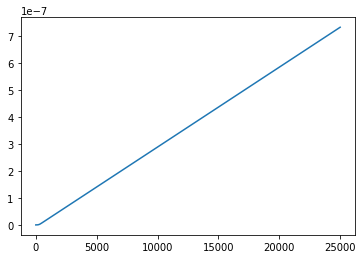

In [109]:
from matplotlib import pyplot as plt
from random import randint
s_output2400 = []
for h in range(total_step+1):
    s_output2400.append(s_output[2400][h][0])
time_list = list(range(total_step+1))
# グラフの描画
plt.plot(time_list, s_output2400)
plt.show()

In [96]:
print(s_output2400)

[7.856907131852334e-07, 3.750742338556112e-07, 7.856907131852332e-07, 3.785316195771132e-07, 7.856907131852333e-07, 3.8198900529861526e-07, 7.856907131852334e-07, 3.854463910201171e-07, 7.856907131852331e-07, 3.889037767416188e-07, 7.856907131852328e-07, 3.9236116246312054e-07, 7.856907131852322e-07, 3.958185481846218e-07, 7.856907131852317e-07, 3.9927593390612327e-07, 7.856907131852322e-07, 4.0273331962762497e-07, 7.85690713185232e-07, 4.061907053491268e-07, 7.85690713185232e-07, 4.0964809107062855e-07, 7.856907131852313e-07, 4.1310547679213094e-07, 7.856907131852307e-07, 4.165628625136333e-07, 7.856907131852305e-07, 4.200202482351357e-07, 7.856907131852298e-07, 4.2347763395663765e-07, 7.856907131852297e-07, 4.2693501967813915e-07, 7.856907131852294e-07, 4.303924053996409e-07, 7.856907131852297e-07, 4.3384979112114235e-07, 7.856907131852296e-07, 4.373071768426444e-07, 7.856907131852296e-07, 4.4076456256414603e-07, 7.856907131852296e-07, 4.44221948285648e-07, 7.85690713185229e-07, 4.47

In [16]:
# モード重畳法定義　(減衰係数は各モードについて減衰定数を用いてモード質量から算出)
def mode_superimposition_method(kt, mt, ft, ramda, x):
    q = np.zeros((nmode, total_step+1, 1)) #一般化変位設定
    ramda_complex = np.zeros((nmode, 1), dtype=complex)
    ramda_complex = ramda+0.j
    omega = np.zeros((nmode, 1), dtype=complex)
    omega = np.sqrt(ramda)
    # xの並び順が逆になるバグがあるため並び替えるが後で直す
    phi = np.zeros((2*nnode, nmode))
    for i in range(2*nnode):
        for j in range(nmode):
            phi[i, j] = x[i, nmode-j-1]
    kt_a = np.dot(np.dot(phi.T, kt), phi)
    # ct_a = np.dot(np.dot(phi.T, ct), phi)
    mt_a = np.dot(np.dot(phi.T, mt), phi)
    # 各モードについて、タイムステップ毎のfiを求める
    fit = np.zeros((nmode, total_step, 1))
    for i in range(nmode):
        fi = np.zeros((total_step, 1))
        for j in range(total_step):
            fi[j][0] = np.dot(phi.T[i], ft[j])
        fit[i] = fi
    # 各行の処理
    for i in range(nmode):
        # i行目について
        omegai = omega[i][0]
        ki = kt_a[i][i]
        mi = mt_a[i][i]
        ci = 2*mi*hc*omegai
        fi = fit[i]
        qi = np.zeros((total_step+1, 2))
        # 振動方程式を解くloop
        for j in range(total_step):
            p_x = qi[j][0]
            p_v = qi[j][1]
            dvdt = -(ci/mi)*p_v - (ki/mi)*p_x + fi[j][0]/mi
            qi[j+1][1] = p_v+dvdt*delta_t
            qi[j+1][0] = p_x+p_v*delta_t
        for j in range(total_step+1):
            q[i][j][0] = qi[j][0]
#         def func(state, t, mi, ki, ci, fi):
#             qi1, qi2 = state
#             dqi2dt = -(ci/mi)*qi2 - (ki/mi)*qi1 + fi[t/delta_t][0]/mi
#         soli = odeint(func, state0, t, args=(mi, ki, ci, fi))
#         for j in range(soli):
#             q[i][j][0] = soli[j]
    # 重ね合わせ
    output = np.zeros((nnode*2, total_step+1, 1))
    q_a = np.zeros((total_step+1, nmode, 1)) # total_step, nmode, 1の形のものを作る
    for i in range(nmode):
        for j in range(total_step+1):
            q_a[j][i][0] = q[i][j][0]
    delta = np.zeros((total_step+1, nnode*2, 1))
    for i in range(total_step+1):
        delta_i = np.dot(phi, q_a[i])
        delta[i] = delta_i
    # ノード毎で変位を見れるよう変更
    for i in range(total_step+1):
        for j in range(nnode*2):
            output[j][i][0] = delta[i][j][0]
    return output, q

In [17]:
output, q = mode_superimposition_method(kt, mt, ft, ramda, x)

/opt/anaconda3/envs/graduation_thesis/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
/opt/anaconda3/envs/graduation_thesis/lib/python3.7/site-packages/ipykernel_launcher.py:12: ComplexWarning: Casting complex values to real discards the imaginary part
  if sys.path[0] == '':


In [20]:
print(q[0])

[[ 0.]
 [ 0.]
 [nan]
 ...
 [nan]
 [nan]
 [nan]]


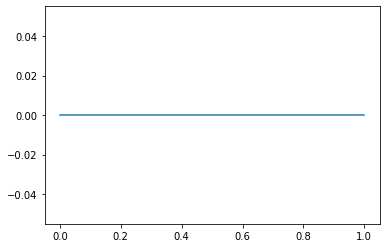

In [18]:
from matplotlib import pyplot as plt
from random import randint

# データの定義(サンプルなのでテキトー)
time_list = list(range(total_step+1))
output_0 = []
for i in range(total_step+1):
    output_0.append(output[2400][i][0])

# グラフの描画
plt.plot(time_list, output_0)
plt.show()